<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/MediaContensAnalysis_Bert_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#10조. 네이버 댓글 분석을 통한 상위, 하위 클립 예측

### #1. 구글 인증

In [1]:
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


### #2. 입력 데이터셋 확인

In [2]:
!ls ../gdrive/My\ Drive/output

file_ep10.csv	 file_ep16.csv	file_ep22.csv  file_ep4.csv
file_ep11.csv	 file_ep17.csv	file_ep23.csv  file_ep5.csv
file_ep12.csv	 file_ep18.csv	file_ep24.csv  file_ep6.csv
file_ep13.csv	 file_ep19.csv	file_ep25.csv  file_ep7.csv
file_ep14_1.csv  file_ep1.csv	file_ep26.csv  file_ep8.csv
file_ep14.csv	 file_ep20.csv	file_ep2.csv   file_ep9.csv
file_ep15.csv	 file_ep21.csv	file_ep3.csv   TheLastEmpress.csv


### #3. 필요 패키지 Install

In [3]:
!pip install regex
# Okt, Kkma 등의 형태소 분석기 활용을 위한 설치
# !pip install konlpy
# Bert 사용을 위한 설치
!pip install sacremoses sentencepiece 

     |████████████████████████████████| 675kB 5.0MB/s 
  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609176 sha256=a8b1cc06c8d4655512b4e6234ecf0bd3ba59e73638099f9fcb0f100c50e0ff1c
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
Successfully built regex
     |████████████████████████████████| 860kB 5.0MB/s 
     |████████████████████████████████| 1.0MB 54.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=d0908a838c34db5fd3cf46e9e8ebbd1b337f793cfa33e6522ac797ea61ee8e49
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


### #4.라이브러리 로드

In [4]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys
import regex as re
import random

from tqdm import tqdm_notebook, trange
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences


#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#데이터 분리를 위한 라이브러리 로드
from sklearn.model_selection import train_test_split

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

Using TensorFlow backend.


### #5. 입력 데이터 Load 및 데이터 정제, 타겟 분리

In [5]:
# 입력으로 활용할 데이터셋 List 확인
filelist = os.listdir('../gdrive/My Drive/output')

# 총 26회차 491개 하이라이트 클립 존재 (전체 재생수 = 107,221,654 / 클립 당 평균 재생수 = 218,374), 
# 이 중에서 예고편, 미공개, 인터뷰 등 클립 제외하고 총 422회 클립 대상
df_title = pd.read_csv('../gdrive/My Drive/output/TheLastEmpress.csv', encoding = 'euc-kr')
df_title.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 조회수 분포를 고려하여 각 회차별로 조회수 상위 4개, 하위 4개 클립을 샘플링 - 총 208개 클립
# 좋아요수, 댓글 수, 댓글 내용, 댓글 작성자 정보 (웹크롤링 통한 추출)

df_ep_tot = pd.DataFrame()

# 상위 하위 클립을 나누어 조회수 내림차순으로 rank를 매김 (1~4는 상위 클립, 5~8은 하위 클립)
for i in tqdm_notebook(filelist):
  if (i[:4] == 'file'):
    df_ep_temp = pd.read_csv('../gdrive/My Drive/output/'+i)
    df_ep_temp['play'] = df_ep_temp['play'].apply(lambda x: int(re.sub(',','', x[4:])))
    df_ep_temp['rank'] = df_ep_temp['play'].rank(method='dense', ascending=False)
    df_ep_tot = df_ep_tot.append(df_ep_temp)

# 크롤링 한 데이터에서 불필요한 열 삭제
df_ep_tot.drop(columns='Unnamed: 0', inplace=True)

# 상위 클립은 1로 하위 클립은 0으로 분류
df_ep_tot['target'] = np.where(df_ep_tot['rank']<=4,1,0)
df_ep_tot

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
1,핑크에메랄드,왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...,2,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
2,서지안,ㅋㅋㅋㅋㅋㅋㅋㅋ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
3,경,ㅏ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
4,홍홍,이게 나라냐? 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발,3,5,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1841,Major,와 ㅅㅂ...피지컬봐....,550,1,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1842,스폰지밥,"이쁘십니다 할때 나만설렜냐,,,,,,,",691,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1843,박한별,반했네,372,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1844,김민정,죄송하지만 이 분 이용합시다 ! 어쨌든 좋은게 좋은거죠 ..,593,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0


### #6. 데이터 정제 - 댓글 중 분석 대상이 되는 contens 내 null data 삭제

In [6]:
df_ep_sample = df_ep_tot.copy()
df_ep_sample.dropna(how='any', inplace=True)
df_ep_sample.info()
df_ep_sample['target'].value_counts() # 3:1 imbalanced dataset (조회수가 많은 클립에 댓글이 많기 때문임))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40801 entries, 0 to 1845
Data columns (total 11 columns):
nick           40801 non-null object
contents       40801 non-null object
recomm         40801 non-null int64
unrecomm       40801 non-null int64
title          40801 non-null object
play           40801 non-null int64
like           40801 non-null object
reple_count    40801 non-null object
episode        40801 non-null int64
rank           40801 non-null float64
target         40801 non-null int64
dtypes: float64(1), int64(5), object(5)
memory usage: 3.7+ MB


1    30632
0    10169
Name: target, dtype: int64

### #4. 데이터 길이 확인

In [0]:
# import konlpy
# from konlpy.tag import Kkma
# from konlpy.utils import pprint

# kkma = Kkma()

# def morphs_kkma(x):
#   res = kkma.morphs(x)
#   if len(res) >= 1:
#     res = [re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) for i in range(len(res)) if re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) != '' and len(res[i]) >= 1]
#   else:
#     res = ''
#   res = '' if not res else res
#   return res

#### #4-1. 데이터 정제 - 정규식 & 형태소 분석

In [0]:
df_ep_sample['contents'] = df_ep_sample['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_ep_sample.dropna(how='any', inplace=True)
df_sample_final = df_ep_sample.sample(frac=0.2).copy()
# df_sample_final = pd.concat([df_ep_sample[df_ep_sample['target']==1].sample(n=10000), df_ep_sample[df_ep_sample['target']==0].sample(n=10000)])
# df_sample_final.sample(frac=1).reset_index(drop=True)
# df_sample_final['target'].value_counts()

### 6. Word Embedding을 위한 Hyper parameter Tuning

In [9]:
# Hyper Param setting

# token의 Histogram 분포를 바탕으로 대부분의 단어 길이 cover 가능한 단어 개수 찾기
# # 신경망 학습을 위한 input 벡터 길이로 사용 - 적정 길이는 tokenizng 이후 분포를 보고 결정(코드 하단)
# totalLenSent = [len(x) for x in df_ep_sample['kkma_token']] # 각 document의 단어 길이를 check
# plt.hist(totalLenSent,bins = np.arange(0,max(totalLenSent),max(totalLenSent)/20))

# print(np.percentile(totalLenSent, 95)) # 95%를 커버하는 수치는 41

# MAX_LEN = int(np.percentile(totalLenSent, 95)) but bert는 128 embedding 사용
MAX_LEN = 64
print(MAX_LEN)

# pre-trained Embedding을 몇 개 사용할 지 결정
# NUM_MODELS = 1

# # input data 원문에서 보존할 최대 단어 개수 
# # 전체 데이터셋에서 나타나는 unique 한 단어 수(넉넉하게 백단위 올림하여 setting)
# from itertools import chain

# sum_lists = list(chain.from_iterable(df_ep_sample['okt_token']))
# totalCntWords = int(math.ceil(len(set(sum_lists))/100)*100)

# MAX_FEATURES = 37000
# MAX_FEATURES = totalCntWords
# print(len(set(sum_lists)), MAX_FEATURES)

64


### #7. 데이터를 Bert 친화 형식으로 변경

In [10]:
# Bert 친화 형식으로 변경

all_df_bert = pd.DataFrame({
    'id':range(len(df_sample_final)),
    'label':df_sample_final['target'],
    'alpha':['a']*df_sample_final.shape[0],
    'text': df_sample_final['contents'].replace(r'\n', ' ', regex=True)
})
display(all_df_bert.head())

# train_df_bert = pd.DataFrame({
#     'id':range(len(train_df)),
#     'label':train_df['target'],
#     'alpha':['a']*train_df.shape[0],
#     'text': train_df['contents'].replace(r'\n', ' ', regex=True)
# })

# display(train_df_bert.head())

# dev_df_bert = pd.DataFrame({
#     'id':range(len(test_df)),
#     'label':test_df['target'],
#     'alpha':['a']*test_df.shape[0],
#     'text': test_df['contents'].replace(r'\n', ' ', regex=True)
# })

# display(dev_df_bert.head())

,id,label,alpha,text
728,0,1,a,아리공주 너무 귀여웤ㅋㅋㅋㅋㅋㅋ 더빙 완벽ㅋㅋㅋㅋㅋ
191,1,0,a,근데 중요한게 서강희도 태후가 태황태후 죽인거 봤음
76,2,1,a,어디가
951,3,1,a,오이 좀 행복하게 해주라 ㅠㅠ
601,4,1,a,조마조마한 맘에봤네천우빈은 엄마의 복수를 하겠다고 이혁한테 접근했는데 태후 이...


In [0]:
all_df_bert.to_csv('../gdrive/My Drive/data/bert/all.tsv', sep='\t', index=False, header=False)
# train_df_bert.to_csv('../gdrive/My Drive/data/bert/train.tsv', sep='\t', index=False, header=False)
# dev_df_bert.to_csv('../gdrive/My Drive/data/bert/test.tsv', sep='\t', index=False, header=False)

### #8. 데이터를 불러와 Tokenizing 준비

In [12]:
# Create sentence and label lists
df_all = pd.read_csv("../gdrive/My Drive/data/bert/all.tsv", delimiter='\t', header=None, names = ['id', 'label', 'alpha', 'text'])
print(df_all.shape)
df_all.sample(5)
# df_train = pd.read_csv("../gdrive/My Drive/data/bert/train.tsv", delimiter='\t', header=None, names = ['id', 'label', 'alpha', 'text'])
# df_test = pd.read_csv("../gdrive/My Drive/data/bert/test.tsv", delimiter='\t', header=None, names = ['id', 'label', 'alpha', 'text'])
# print(df_train.shape, df_test.shape)
# df_train.sample(5)

(8160, 4)


,id,label,alpha,text
1653,1653,1,a,ㅋㅋㅋㅋㅋㅋㅋㅋ최팀장ㅋㅋㅋㅋㅋㅋㅋ
6211,6211,1,a,세 가족의 단란한 한 때 ㅎㅎ
2839,2839,1,a,겁나 쭈굴 ㅋㅋㅋㅋㅋㅋㅋ뒷구르기
5569,5569,1,a,장나라씨 나온다해서 밝고 유쾌한 드라마라 생각하고 아이들하고 어제 처음 시청 했는데...
4751,4751,1,a,너무 웃었어요 어제ㅋㅋㅋㅋ 어찌나 저렇게 깜찍하고 연기를 잘하는지ㅋㅋㅋㅋ


In [13]:
sentences = df_all.text.values
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = df_all.label.values
len(sentences)

8160

### #9. Pytorch 환경 내에서 BERT를 사용하기 위한 BERT 관련 Library Load

In [14]:
!pip install transformers

     |████████████████████████████████| 368kB 4.7MB/s 


In [0]:
import sacremoses
import sentencepiece

import pickle
import shutil
from joblib import Parallel, delayed

import torch
import torch.nn as nn # for neural net
import torch.utils.data
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss

from IPython.core.interactiveshell import InteractiveShell # jupyter에서 마지막 값만 출력하는게 아니라 모든 출력값을 매번 연속적으로 출력
InteractiveShell.ast_node_interactivity = "all" # all, last, last_expr, none (기본값은 'last_expr')

# from transformers import convert_tf_checkpoint_to_pytorch
from transformers import convert_bert_original_tf_checkpoint_to_pytorch

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, BertModel, BertPreTrainedModel, BertConfig
from transformers.optimization import get_linear_schedule_with_warmup

from transformers import BertConfig # This is the Bert configuration file

### #10. Bert 학습을 위한 경로 설정

In [37]:
!mkdir ./bert_work/
PATH_PRETRAINED = "../gdrive/My Drive/data/bert/multi_cased_L-12_H-768_A-12/"
PATH_TORCH_PRETRAINED = "../gdrive/My Drive/data/bert/bert-base-multilingual-cased/"
PATH_HUGGING = "../gdrive/My Drive/data/bert/huggingface/"
PATH_WORK = './bert_work/'
sys.path.append(PATH_PRETRAINED)
sys.path.append(PATH_WORK)

mkdir: cannot create directory ‘./bert_work/’: File exists


### #11. Bert 학습을 위한 pretrained model을 pytorch 형태로 변환하여 work 경로로 복사

In [17]:
# convert_bert_original_tf_checkpoint_to_pytorch.convert_tf_checkpoint_to_pytorch(
#     PATH_PRETRAINED + 'bert_model.ckpt',
#     PATH_PRETRAINED + 'bert_config.json',
#     PATH_TORCH_PRETRAINED + 'pytorch_model.bin')

# # 읽어온 BERT_MODEL_PATH bert_config.json file의 설정을 PATH_TORCH_PRETRAINED에 쓰고 복사 후 PATH_WORK의 bert_config.json이라는 이름으로 저장
# shutil.copyfile(PATH_PRETRAINED + 'bert_config.json', PATH_TORCH_PRETRAINED + 'config.json')
# shutil.copyfile(PATH_TORCH_PRETRAINED + 'config.json', PATH_WORK + 'config.json')
# shutil.copyfile(PATH_TORCH_PRETRAINED + 'pytorch_model.bin', PATH_WORK + 'pytorch_model.bin')
# # 읽어온 BERT_MODEL_PATH vocab.txt file의 설정을 그대로 PATH_WORK의 vocab.txt라는 이름으로 저장
# shutil.copyfile(PATH_PRETRAINED + 'vocab.txt', PATH_TORCH_PRETRAINED + 'vocab.txt')
# shutil.copyfile(PATH_TORCH_PRETRAINED + 'vocab.txt', PATH_WORK + 'vocab.txt')

# # 상기 내용 1회 시행 이후는 그냥 PATH_PRETRAINED의 변환 된 파일들을 PATH_WORK로만 복사
# shutil.copyfile(PATH_TORCH_PRETRAINED + 'config.json', PATH_WORK + 'config.json')
# shutil.copyfile(PATH_TORCH_PRETRAINED + 'pytorch_model.bin', PATH_WORK + 'pytorch_model.bin')
# shutil.copyfile(PATH_TORCH_PRETRAINED + 'vocab.txt', PATH_WORK + 'vocab.txt')


# 상기 내용 1회 시행 이후는 그냥 PATH_PRETRAINED의 변환 된 파일들을 PATH_WORK로만 복사
shutil.copyfile(PATH_HUGGING + 'bert-base-multilingual-cased-config.json', PATH_WORK + 'config.json')
shutil.copyfile(PATH_HUGGING + 'bert-base-multilingual-cased-pytorch_model.bin', PATH_WORK + 'pytorch_model.bin')
shutil.copyfile(PATH_HUGGING + 'bert-base-multilingual-cased-vocab.txt', PATH_WORK + 'vocab.txt')

'./bert_work/config.json'

'./bert_work/pytorch_model.bin'

'./bert_work/vocab.txt'

In [35]:
!ls ../gdrive/My\ Drive/data/bert/huggingface

bert-base-multilingual-cased-config.json
bert-base-multilingual-cased-pytorch_model.bin
bert-base-multilingual-cased-vocab.txt


### #12. BERT 사용 관련 Hyperparameter Setting

In [18]:
seed = 42
MAX_SEQ_LEN = MAX_LEN # token분포 바탕으로 128 선정 (대부분의 단어 길이 cover)

NUM_LABELS = len(df_sample_final['target'].unique()) #2 If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy)
training_epochs = 1
lr = 2e-5
batch_size = 64

FILE_VOCAB = PATH_WORK+'vocab.txt'
bert_model_config = PATH_WORK+'config.json'

bert_model = 'bert-base-multilingual-cased'
do_lower_case = 'uncased' in bert_model
device = torch.device('cuda') # GPU 사용 setting

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### #13. Bert 형식으로 Tokenizing 시행
#### - 여기서는 직접 map을 이용해 직접 vocab을 다운로드

In [19]:
# tokenizer = BertTokenizer.from_pretrained(os.path.join(PATH_WORK, 'vocab.txt'), cache_dir=None, do_lower_case=do_lower_case, do_basic_tokenize=False)
# ['니', '##는', '[UNK]', '황', '##후', '##는', '이', '##짓', '##하면', '##안', '##돼', '##냐', '진', '##실을', '말', '##한', '##것', '뿐', '##인', '##데']

# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=do_lower_case)
tokenizer = BertTokenizer.from_pretrained(FILE_VOCAB, cache_dir=None, do_lower_case=do_lower_case)

for i in range(0, len(sentences), 2000):
  sentence = sentences[i:(i+2000)] 
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentence]
  
  # 2000번에 한개씩 결과 출ㄹ력 
  if (i % 2000) == 0:
    print(tokenized_texts)
    
  input_ids_tmp = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids_tmp = pad_sequences(input_ids_tmp, maxlen=MAX_LEN, dtype="long", truncating='post', padding='post')
  if i==0:
    input_ids = input_ids_tmp
    print(i)
  else:
    input_ids = np.vstack((input_ids, input_ids_tmp))
    print(i, '완료', input_ids.shape, input_ids_tmp.shape)

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt not found in cache or force_download set to True, downloading to /tmp/tmpq0bxccb4
100%|██████████| 995526/995526 [00:00<00:00, 2491878.53B/s]
INFO:transformers.file_utils:copying /tmp/tmpq0bxccb4 to cache at /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
INFO:transformers.file_utils:removing temp file /tmp/tmpq0bxccb4
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadb

[['[CLS]', '아', '##리', '##공', '##주', '너', '##무', '[UNK]', '더', '##빙', '[UNK]', '[SEP]'], ['[CLS]', '근', '##데', '중요한', '##게', '서', '##강', '##희', '##도', '태', '##후', '##가', '태', '##황', '##태', '##후', '죽', '##인', '##거', '봤', '##음', '[SEP]'], ['[CLS]', '어', '##디', '##가', '[SEP]'], ['[CLS]', '오', '##이', '좀', '행', '##복', '##하게', '해', '##주', '##라', '[UNK]', '[SEP]'], ['[CLS]', '조', '##마', '##조', '##마', '##한', '맘', '##에', '##봤', '##네', '##천', '##우', '##빈', '##은', '엄', '##마', '##의', '복', '##수를', '하', '##겠', '##다고', '이', '##혁', '##한', '##테', '접', '##근', '##했', '##는데', '태', '##후', '이', '##혁', '커', '##녕', '벌', '##써', '나', '##왕', '##식으로', '[UNK]', '아', '##깝', '##어', '##느', '##정', '##도', '복', '##수는', '##하고', '들', '##통', '##나', '##야', '##지', '[UNK]', '부', '##작', '소', '##현', '##황', '##후', '##랑', '##사', '##건', '태', '##후', '서', '##강', '##이', '등', '##등', '##은', '누', '##가', '##복', '##수', '##하는', '##겨', '나', '##왕', '##식', '##과', '황', '##후', '##는', '같은', '##편', '##이', '##란', '##것', '##두', '다', '##알', '##고', '

In [20]:
np.save('wordpiece_tokenize_128.npy', input_ids)
input_ids = np.load('wordpiece_tokenize_128.npy')
print(input_ids.shape)
input_ids[:1]

(8160, 64)


array([[   101,   9519,  12692,  28000,  16323,   9004,  32537,    100,
          9074, 119005,    100,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0]])

## 분류에 사용할 클래스 Load

In [0]:
X = input_ids
Y = labels

# Train & Test Set 분리
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [22]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(6528, 64) (1632, 64) (6528,) (1632,)


In [23]:
# Dataset을 상속한 TensorDataset은 train data x와 레이블 y를 묶어놓은 컨테이너로 tensor만 전달 가능함
# X는 torch.long 형태의 텐서로, y는 torch.float 타입의 텐서로 입력하여 pytorch에서 연산할 수 있는 기본 구조로 변경하여 train_dataset으로 할당
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_x,dtype=torch.long), torch.tensor(train_y,dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_x,dtype=torch.long), torch.tensor(test_y,dtype=torch.long))

print(train_x.shape)
print(train_y.shape)

(6528, 64)
(6528,)


In [0]:
train_losses = []

# Train 함수
def bert_train_net(net, train_loader, optimizer, device="cuda"):
  tq = tqdm_notebook(range(training_epochs))

  for epoch in tq:
    tr_loss = 0.
    nb_tr_examples, nb_tr_steps = 0,0

    # 신경망을 훈련 모드로 설정
    net.train()
    tk0 = tqdm_notebook(enumerate(train_loader),total=len(train_loader),leave=False)
    
    # iteration 1회에 train_loader의 batch_size (여기서는 64)만큼씩 읽어와 한꺼번에 batch처리 batch_size * i (여기서는 i = ) 가 전체 train data set의 크기가 될때까지 loop
    for i,(x, y) in tk0:
      x=x.to(device) # len(x)는 batch_size
      y=y.to(device)

      loss, logit = net(x, token_type_ids=None, attention_mask=(x>0).to(device), labels=y)  # forward

      optimizer.zero_grad() # step과 zero_grad는 쌍을 이루는 것이라고 생각하면 됨 # optimizer의 gradient를 0으로 초기화
      
      if (i%200) == 0:
        print("loss ... ", loss, type(loss))
        print("logit ... ", logit, type(logit))
      train_losses.append(loss.item())

      loss.backward() # backpropagation
      optimizer.step() # update gradients

      # update tracking variables
      tr_loss += loss.item()
      nb_tr_examples += x.size(0)
      nb_tr_steps += 1
      # running_loss += loss.item() # loss calculate

      train_losses.append(tr_loss/nb_tr_steps)

    print("epoch: {}/{} | train_loss: {:.4f} ".format(epoch, training_epochs, tr_loss/nb_tr_steps))
    # train_losses.append(running_loss/len(train_loader))
    # torch.save(model.state_dict(), output_model_file)

In [25]:
!ls ./bert_work

config.json  pytorch_model.bin	vocab.txt


In [38]:
# BertForSequenceClassification is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. 
# As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

# Load pre-trained model (weights)

CACHE_DIR = 'cache/'

# model = BertForSequenceClassification.from_pretrained(bert_model, cache_dir=CACHE_DIR, num_labels=NUM_LABELS)
model = BertForSequenceClassification.from_pretrained(PATH_WORK, num_labels=NUM_LABELS)
# model = BertForSequenceClassification.from_pretrained(CACHE_DIR + 'cased_base_bert_pytorch.tar.gz', cache_dir=CACHE_DIR, num_labels=num_labels)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

### In Transformers, optimizer and schedules are splitted and instantiated like this:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=lr, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

INFO:transformers.configuration_utils:loading configuration file ./bert_work/config.json
INFO:transformers.configuration_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 119547
}

INFO:transformers.modeling_utils:loading weights file ./bert_work/pytorch_model.bin
INFO:transformers

In [0]:
# !ls ../gdrive/My\ Drive/data/bert/huggingface

In [28]:
model.to(device) # GPU 연산을 위해 cuda로 전송

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
bert_train_net(model, train_loader, optimizer, device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

loss ...  tensor(0.7040, device='cuda:0', grad_fn=<NllLossBackward>) <class 'torch.Tensor'>
logit ...  tensor([[ 1.3484e-01,  1.8413e-01],
        [ 3.1824e-01,  6.1054e-02],
        [ 1.0133e-01,  5.0975e-02],
        [ 1.0204e-01,  4.9818e-02],
        [ 1.1291e-01,  1.4188e-01],
        [ 1.4573e-01,  4.5506e-02],
        [ 1.3450e-01,  3.2100e-02],
        [ 1.0806e-01,  4.9487e-02],
        [ 2.5339e-01,  1.5748e-01],
        [ 1.7404e-01,  1.3439e-02],
        [ 6.5938e-02, -1.7786e-04],
        [ 1.0853e-01,  9.7449e-02],
        [ 8.3558e-02,  7.3778e-02],
        [ 1.0049e-01, -4.8090e-02],
        [ 2.7805e-01,  1.0918e-01],
        [ 1.5947e-01,  2.5257e-01],
        [ 6.3020e-02,  1.4116e-01],
        [ 1.7235e-01,  9.8912e-02],
        [ 1.0020e-01,  9.8253e-02],
        [ 1.0166e-01,  6.1144e-02],
        [ 2.2431e-01, -2.4074e-02],
        [ 1.3221e-01,  1.1228e-01],
        [ 2.1164e-01,  8.5095e-02],
        [ 1.0294e-01, -4.6729e-02],
        [ 1.3912e-01,  6.9369e-02

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Training loss')

Text(0.5, 0, 'Batch')

Text(0, 0.5, 'Loss')

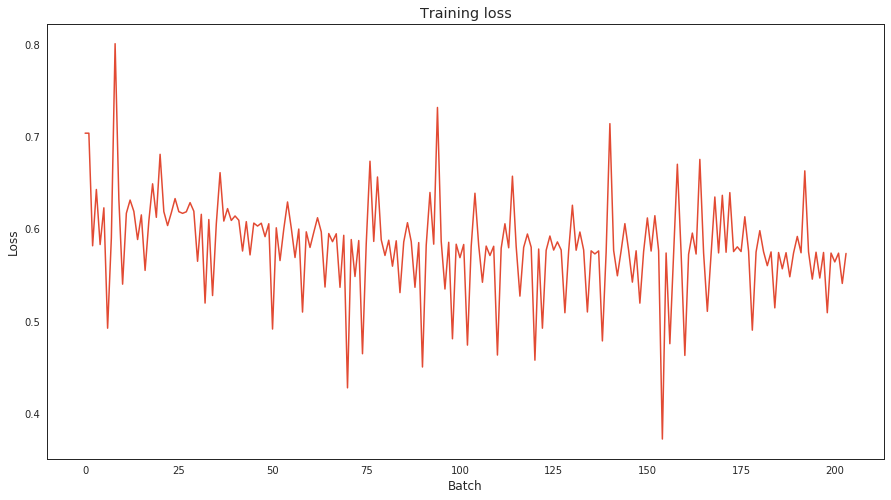

In [29]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_losses)
plt.show()

In [0]:
preds = []
labels = []

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(y_preds, real_ys):
    pred_flat = np.argmax(y_preds, axis=1).flatten()
    labels_flat = real_ys.flatten()
    print("pred_flat is ", pred_flat)
    print("labels_flat is ", labels_flat)
    preds.append(pred_flat)
    labels.append(labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# 평가 헬퍼 함수
def bert_eval_net(net, data_loader, device="cuda"):
  # Dropout 및 BatchNorm 무효화
  net.eval()

  eval_acc = 0
  nb_eval_examples, nb_eval_steps = 0,0

  for x, y in data_loader:
    x=x.to(device)
    y=y.to(device)
    with torch.no_grad():
      y_preds = net(x, token_type_ids=None, attention_mask=(x>0).to(device), labels=None)  # forward

    #Move logits and labels to CPU
    y_preds = y_preds[0].detach().cpu().numpy()
    real_ys = y.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(y_preds, real_ys)
    print("tmp_eval_accuracy : ", tmp_eval_accuracy)

    eval_acc += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_acc/nb_eval_steps))

In [32]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
bert_eval_net(model, test_loader, device)

pred_flat is  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels_flat is  [0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1]
tmp_eval_accuracy :  0.78125
pred_flat is  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels_flat is  [1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1]
tmp_eval_accuracy :  0.765625
pred_flat is  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels_flat is  [0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0
 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1]
tmp_eval_accuracy :  0.6875
pred_flat is  [1 1 1 1 1 1 1 1 1 1 1 

In [0]:
def result_summary(pred_y, real_y):
  print("Accuracy: {:.4f}".format(accuracy_score(real_y, pred_y)))
  print("Confusion Matrix: \n", confusion_matrix(real_y, pred_y))
  print("Classification Report Matrix: \n", classification_report(real_y, pred_y, digits=3))

  roc_auc = roc_auc_score(real_y, pred_y)
  print("roc_auc score is : {:.4f}".format(roc_auc))

  fpr, tpr, threshold = roc_curve(real_y, pred_y)
  roc_auc = auc(fpr, tpr)

  auc_graph(roc_auc, fpr, tpr)

def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

### 최종 List를 하나의 List로 펴줌

Accuracy: 0.7567
Confusion Matrix: 
 [[   0  397]
 [   0 1235]]
Classification Report Matrix: 
               precision    recall  f1-score   support

           0      0.000     0.000     0.000       397
           1      0.757     1.000     0.862      1235

    accuracy                          0.757      1632
   macro avg      0.378     0.500     0.431      1632
weighted avg      0.573     0.757     0.652      1632

roc_auc score is : 0.5000


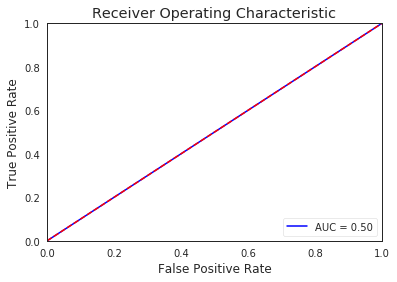

In [34]:
import itertools
preds_flat = list(itertools.chain(*preds))
labels_flat = list(itertools.chain(*labels))

result_summary(preds_flat, labels_flat)